In [19]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

### LOAD FLOWER DATASET

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 2s 0us/step


In [13]:
data_dir

'./datasets/flower_photos'

In [14]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [15]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/sunflowers/9482209981_bf7bf6022b_m.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/15054752730_fcf54d475e_m.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/6606749757_b98a4ba403.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/9484354480_07ff2ef0a6.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/6140808687_88df0fd733.jpg')]

In [16]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [17]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/5492988531_574cdc2bf0_n.jpg'),
 PosixPath('datasets/flower_photos/roses/20409866779_ac473f55e0_m.jpg'),
 PosixPath('datasets/flower_photos/roses/8337607102_d9e0fa887e.jpg'),
 PosixPath('datasets/flower_photos/roses/7251352826_69b62cba2c_m.jpg'),
 PosixPath('datasets/flower_photos/roses/2059172936_032ffc12aa.jpg')]

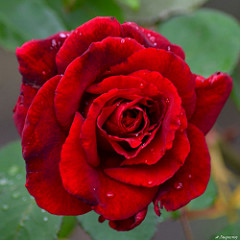

In [21]:
Image.open(str(roses[1]))

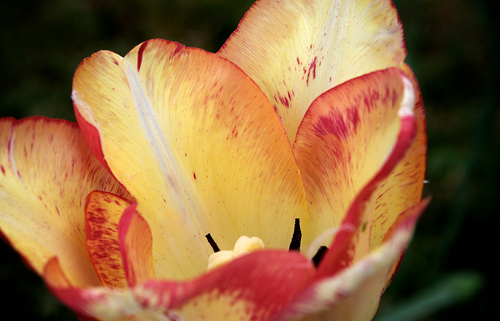

In [22]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

### Read flowers images from disk into numpy array using opencv

In [23]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [24]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [25]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/5492988531_574cdc2bf0_n.jpg'),
 PosixPath('datasets/flower_photos/roses/20409866779_ac473f55e0_m.jpg'),
 PosixPath('datasets/flower_photos/roses/8337607102_d9e0fa887e.jpg'),
 PosixPath('datasets/flower_photos/roses/7251352826_69b62cba2c_m.jpg'),
 PosixPath('datasets/flower_photos/roses/2059172936_032ffc12aa.jpg')]

In [26]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/5492988531_574cdc2bf0_n.jpg'

In [28]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [29]:
img.shape

(240, 320, 3)

In [30]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [31]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [32]:
X = np.array(X)
y = np.array(y)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [34]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

### Make prediction using pre-trained model on new flowers dataset

In [35]:
X[0].shape

(224, 224, 3)

In [36]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

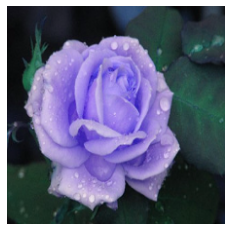

In [37]:
plt.axis('off')
plt.imshow(X[0])

In [39]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

In [40]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 602ms/step


array([795, 722, 550])

In [44]:
 tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 [==============================] - 0s 0us/step


'/root/.keras/datasets/ImageNetLabels.txt'

In [46]:
image_labels = []
with open("/root/.keras/datasets/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [49]:
image_labels[550]

'envelope'

### Now take pre-trained model and retrain it using flowers images

In [50]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [51]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [52]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 86s 945ms/step - loss: 0.8044 - acc: 0.6937
Epoch 2/5
86/86 [==============================] - 81s 937ms/step - loss: 0.4173 - acc: 0.8637
Epoch 3/5
86/86 [==============================] - 80s 934ms/step - loss: 0.3313 - acc: 0.8921
Epoch 4/5
86/86 [==============================] - 81s 938ms/step - loss: 0.2703 - acc: 0.9157
Epoch 5/5
86/86 [==============================] - 80s 935ms/step - loss: 0.2345 - acc: 0.9295


In [53]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 28s 918ms/step - loss: 0.3461 - acc: 0.8780


[0.34611454606056213, 0.8779956698417664]